In [1]:
import numpy as np
import matplotlib.pyplot as plt

![](realized_labeled_schem_small.png)

In [3]:
# Initialise Variables:

Dt = 0.0005
t_start,t_end = 0,100
n_steps = int(round((t_end-t_start)/Dt))

x0,y0,z0 = 1.e-5,1.e-5,1.e-5

x = x0

C1  = 10*10^(-9);   #10nF
C2  = 100*10^(-9);  #100nF
R = 1800;           #1.8k Ohms
G = 1/R;

#Chua Diode*************************************
R1 = 220
R2 = 220
R3 = 2200
R4 = 22000
R5 = 22000
R6 = 3300

Esat = 9 #9V batteries
E1 = R3/(R2+R3)*Esat
E2 = R6/(R5+R6)*Esat

m12 = -1/R6
m02 = 1/R4
m01 = 1/R1
m11 = -1/R3

m1 = m12+m11

m0 = m11 + m02 if E1 > E2 else m12 + m01

mm1 = m01 + m02;
Emax = max([E1,E2])
Emin = min([E1,E2])

if abs(x) < Emin:
    g = x*m1   
elif abs(x) < Emax:
    g = x*m0
    if x > 0:
        g = g + Emin*(m1-m0)    
    else:
        g = g + Emin*(m0-m1)  
elif abs(x) >= Emax:
    g = x*mm1   
    if x > 0:
        g = g + Emax*(m0-mm1) + Emin*(m1-m0)
    else:
        g = g + Emax*(mm1-m0) +  Emin*(m0-m1)

In [4]:
#Gyrator*********************************
R7  = 100  #100 Ohms
R8  = 1000 #1k Ohms
R9  = 1000 #1k Ohms
R10 = 1800
C   = 100*10^(-9) #100nF
L = R7*R9*C*R10/R8 #18mH 

In [26]:
from scipy.integrate import odeint

# Chua's Circuit Equations
xdot = (1/C1)*(G*(y-x)-g);
ydot = (1/C2)*(G*(x-y)+z);
zdot  = -(1/L)*y;

out = [xdot ydot zdot]';

# NOT FINISHED
def chua(v,t,a,b,m0,m1):
    def g(x,m1,m0,mm1,Emin,Emax):
        if abs(x) < Emin:
            g = x*m1   
        elif abs(x) < Emax:
            g = x*m0
            if x > 0:
                g = g + Emin*(m1-m0)    
            else:
                g = g + Emin*(m0-m1)  
        elif abs(x) >= Emax:
            g = x*mm1   
            if x > 0:
                g = g + Emax*(m0-mm1) + Emin*(m1-m0)
            else:
                g = g + Emax*(mm1-m0) +  Emin*(m0-m1)
    
    def fx(x,m0=m0,m1=m1):
        return m1*x + 0.5*(m0-m1)*(np.abs(x+1) - np.abs(x-1))

    def dxdt(x,y,a=a):
        return a*(y-x-fx(x))

    def dydt(x,y,z):
        return (x - y + z)

    def dzdt(y,b=b):
        return -b*y
    
    x,y,z = v
    return [dxdt(x,y),dydt(x,y,z),dzdt(y)]

v0 = [x0,y0,z0]
t = np.linspace(0,100,100001)
sol = odeint(chua,v0,t,args=(a,b,m0,m1))

C:\Users\U0018301\AppData\Local\Temp/ipykernel_14896/3024624116.py:5: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


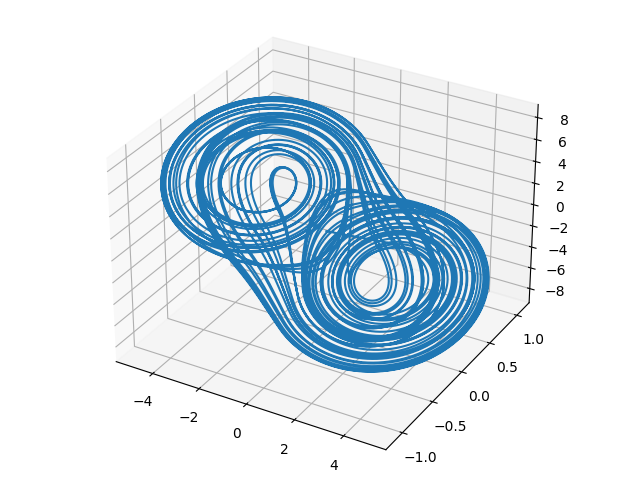

In [27]:
%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)

ax.plot(sol.T[0],sol.T[1],sol.T[2])